In [51]:
import requests
import base64
from io import BytesIO
from PIL import Image

URL_API = "http://localhost:5000"

def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


In [72]:
#image_path = "image/coconut.jpg"
image_path = "image/fake.jpg"

Classify the input image

In [73]:
url = URL_API + "/classify"

encoded_image = encode_image_to_base64(image_path)
payload = {"image": encoded_image}
response = requests.post(url, json=payload)
response.text

'not a fruit or vegetable'

Transform the image using the pipeline

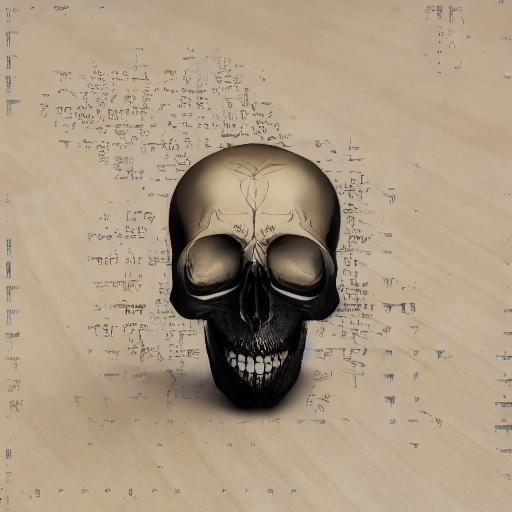

In [74]:
prompt = "A photo of a skull"

url = URL_API + "/transform"

encoded_image = encode_image_to_base64(image_path)
payload = {"image": encoded_image,
          "prompt": prompt}

response = requests.post(url, json=payload)

base64_image = response.text.replace("data:image/jpeg;base64,", "")
image_file = BytesIO(base64.b64decode(base64_image))

image = Image.open(image_file)

image